In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
import scipy.stats as stats
import geopandas as geop
#import xgboost as xgb
import cartopy
import hashlib
from timeit import timeit
import pickle
import category_encoders as ce


#from pandas.tools.plotting import scatter_matrix
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, LassoLarsIC, Lasso, BayesianRidge, Ridge, LassoLars, LassoLarsCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, Imputer
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, ParameterSampler, StratifiedShuffleSplit

warnings.filterwarnings('ignore')

In [2]:
# Importamos nuestro dataset
df_raw = pd.read_csv('data/train.csv', low_memory=False, parse_dates=["fecha"])

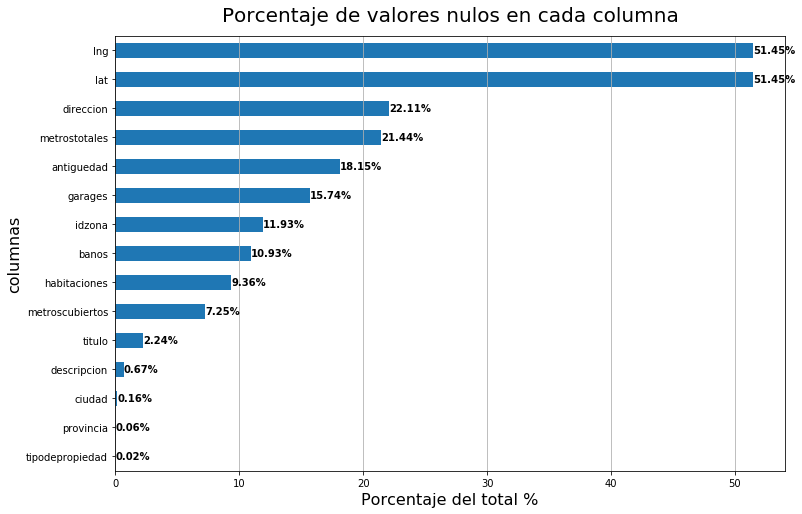

In [3]:
# Definimos una funcion para analizar nulls
def nulls(df):
    nulls = pd.DataFrame((df.isnull().sum().sort_values()/len(df)*100).round(2),columns=['porcentaje de NaN'])
    nulls.drop(nulls.loc[nulls.loc[:,'porcentaje de NaN']<=0].index, inplace=True)
    plt.figure(figsize=(12,8))
    ax = nulls['porcentaje de NaN'].plot.barh()
    ax.set_title('Porcentaje de valores nulos en cada columna',fontsize=20, y=1.02)
    ax.set_xlabel('Porcentaje del total %', fontsize=16)
    ax.set_ylabel('columnas', fontsize=16)
    ax.grid(axis='x')

    for y, x in enumerate(nulls['porcentaje de NaN']):
        ax.text(x, y, s=str(x)+'%', color='black', fontweight='bold',va='center')
        
    plt.show()

nulls(df_raw)

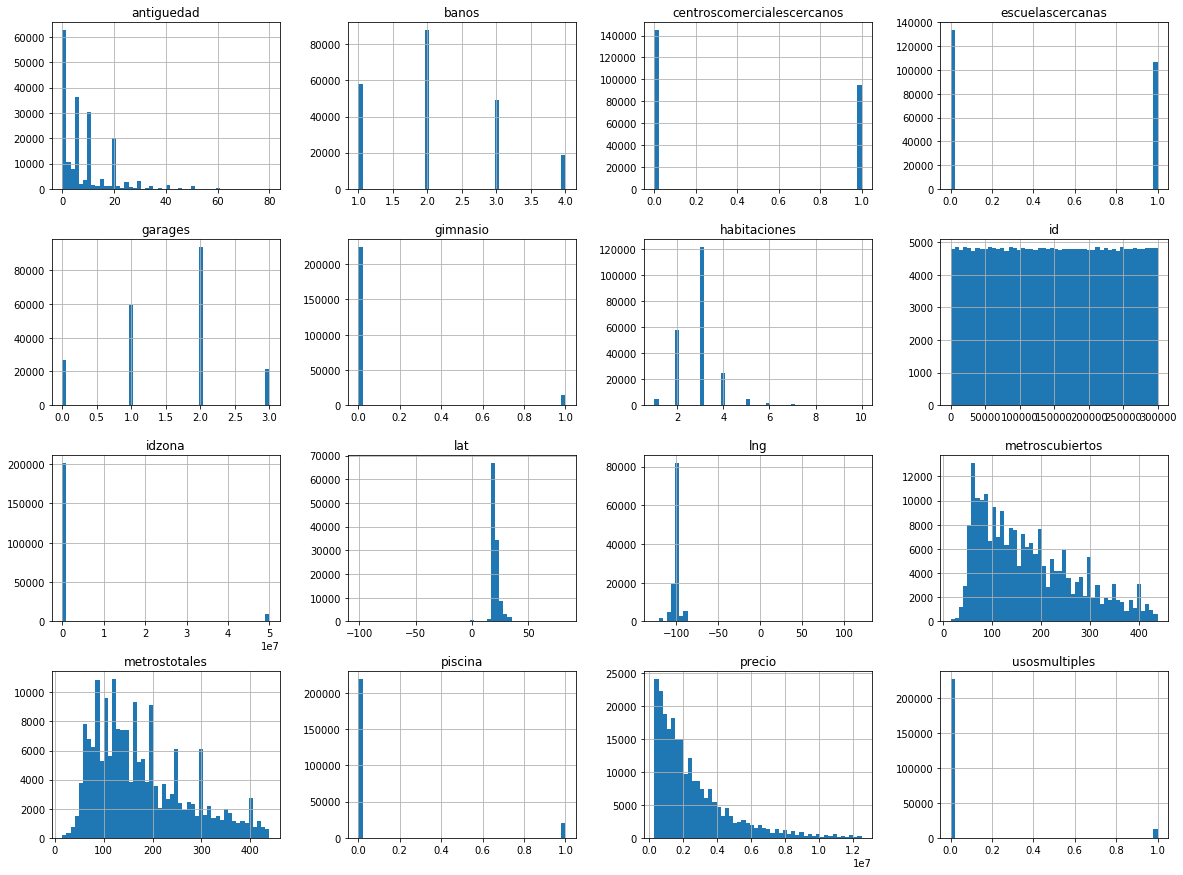

In [4]:
# Veamos a simple vista como se distribuyen nuestras variables cuantitativas
df_raw.hist(bins=50, figsize=(20,15))
plt.show()

In [5]:
# Para evitar un Snooping Bias, vamos a generar el training set y test set, de una.
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [6]:
train_set, test_set = split_train_test(df_raw,0.2)
print(len(train_set), " train + ", len(test_set), " test")

# Ahora me encuentro con el problema, de que cada vez que corro el Kernel, estoy analizando un sector distinto de mis datos.
# Esto es un problema, porque a medida que siga corriendo mis Kernels, voy a navegar todos mis datos (= Overfitting!)

192000  train +  48000  test


In [7]:
# Esto se soluciona generando un train y test ligado a la firma de hash de un seed fijo -- en este caso el id.

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [8]:
train_set, test_set = split_train_test_by_id(df_raw, 0.2, 'id')

# El problema acá es que si borramos algún dato, esto se va ver reflejado en la firma del hash.
# Así que nos queda resetear el indice para agregarle uno generico al dataset

df_raw_wid = df_raw.reset_index()
train_set, test_set = split_train_test_by_id(df_raw_wid, 0.2, 'index')

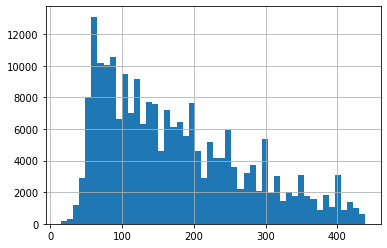

In [9]:
# Consideremos ahora, el problema de que nuestro muestreo no adhiere a los estratos (Stratisfied Sampling)
# Siguiendo al analisis exploratorio de nuestro primer TP, podemos apreciar que metros cubiertos es un factor
# muy importante.

df_raw.metroscubiertos.hist(bins = 50)

# Generemos pues, categorias que nos permitan hacer una aproximacion discreta al continuo de metroscubiertos.

df_raw['metrosc_cat'] = np.ceil(df_raw.metroscubiertos/150)
df_raw['metrosc_cat'].where(df_raw.metroscubiertos < 450, 4, inplace=True)

In [10]:
# Ahhhh, pero a que no sabian que sklearn RESUELVE TODO ESTA MIERDA!
train_set, test_set = train_test_split(df_raw, test_size = 0.2, random_state = 42)

In [11]:
df_raw['antig_cat'] = np.ceil(df_raw.antiguedad/150)
df_raw['antig_cat'].where(df_raw.antiguedad < 50, 4, inplace=True)
df_raw['hab_cat'] = np.ceil(df_raw.habitaciones/1.5)
df_raw['hab_cat'].where(df_raw.habitaciones < 7, 4, inplace=True)

In [12]:
# Y asi, generamos nuestro test y train set estratificado.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_raw, df_raw.metrosc_cat):
    strat_train_set = df_raw.loc[train_index]
    strat_test_set = df_raw.loc[test_index]
strat_train_set['metrosc_cat'] = np.ceil(strat_train_set.metroscubiertos/150)
strat_train_set['metrosc_cat'].where(strat_train_set.metroscubiertos < 450, 4, inplace=True)
for train_index, test_index in split.split(df_raw, df_raw.antig_cat):
    strat_train_set = df_raw.loc[train_index]
    strat_test_set = df_raw.loc[test_index]
strat_train_set['antig_cat'] = np.ceil(strat_train_set.antiguedad/1.5)
strat_train_set['antig_cat'].where(strat_train_set.antiguedad < 50, 4, inplace=True)
for train_index, test_index in split.split(df_raw, df_raw.antig_cat):
    strat_train_set = df_raw.loc[train_index]
    strat_test_set = df_raw.loc[test_index]
strat_train_set['hab_cat'] = np.ceil(strat_train_set.habitaciones/1.5)
strat_train_set['hab_cat'].where(strat_train_set.habitaciones < 7, 4, inplace=True)

In [13]:
# Comparemos el estratificado con el real.
print(train_set.metrosc_cat.value_counts() / len(train_set),\
      df_raw.metrosc_cat.value_counts() / len(df_raw),\
      strat_train_set.metrosc_cat.value_counts() / len(strat_train_set))

1.0    0.460630
2.0    0.351255
3.0    0.115703
4.0    0.072411
Name: metrosc_cat, dtype: float64 1.0    0.460446
2.0    0.351308
3.0    0.115746
4.0    0.072500
Name: metrosc_cat, dtype: float64 1.0    0.461167
2.0    0.350406
3.0    0.115422
4.0    0.073005
Name: metrosc_cat, dtype: float64


In [14]:
# Ahora que dividimos correctamente nuestro train/test, borremos la categorica y volvamos al df original
for set in (strat_train_set, strat_test_set):
    set.drop(['metrosc_cat'], axis=1, inplace=True)
    set.drop(['antig_cat'], axis=1, inplace=True)
    set.drop(['hab_cat'], axis=1, inplace=True)
    

In [15]:
# Es hora de jugar!
df = strat_train_set.copy()

In [16]:
df.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
173455,106425,venta de casa en condominio en corregidora,la plusvalía de tu inversión en puerta real es...,Casa en condominio,NaN,Corregidora,Querétaro,0.0,3.0,2.0,...,NaN,NaN,NaN,2013-11-04,0.0,0.0,0.0,0.0,0.0,1475000.0
171491,97179,casa en venta en residencial tejeda,casa sola de 1 planta en fraccionamiento tejed...,Casa,Londres 335,Corregidora,Querétaro,20.0,3.0,2.0,...,86235.0,NaN,NaN,2012-07-31,0.0,0.0,0.0,1.0,1.0,900000.0
206391,59024,casa en venta en la col. jardines de huinala,"<p>excelente casa frente a parque, 2 niveles, ...",Casa,NaN,Apodaca,Nuevo León,8.0,3.0,1.0,...,71635.0,NaN,NaN,2015-03-11,0.0,0.0,0.0,0.0,0.0,850000.0
99089,63197,"remato departamento en $700mil, calle boleo, v...",valor comercial: \nprecio de venta: \n\n**un...,Apartamento,BOLEO,Venustiano Carranza,Distrito Federal,5.0,2.0,1.0,...,24979.0,19.456214,-99.123763,2016-12-27,0.0,0.0,0.0,0.0,0.0,700000.0
238537,193118,"casa en venta, col. colinas del sur, del. a ab...",<p>estupenda casa ubicada en la avenida princi...,Casa,CALZADA DE LAS CARRETAS,Alvaro Obregón,Distrito Federal,28.0,3.0,2.0,...,23263.0,19.367000,-99.222352,2013-09-29,0.0,0.0,0.0,1.0,1.0,5700000.0


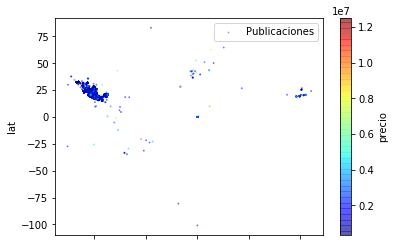

In [17]:
df.plot(kind='scatter', x='lng', y='lat',alpha=0.4, s=df.id.value_counts(), \
        label='Publicaciones', c="precio", cmap=plt.get_cmap('jet'), colorbar=True)

In [18]:
corr_matrix = df.corr()

In [19]:
corr_matrix['precio'].sort_values(ascending=False)

precio                        1.000000
metroscubiertos               0.630241
banos                         0.534146
metrostotales                 0.514448
garages                       0.351114
habitaciones                  0.252065
gimnasio                      0.152562
usosmultiples                 0.143374
piscina                       0.112353
antiguedad                    0.076148
idzona                        0.074017
lng                           0.050185
centroscomercialescercanos    0.026063
escuelascercanas              0.000248
id                           -0.000416
lat                          -0.155437
Name: precio, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D2A84EB128>,
      dtype=object)

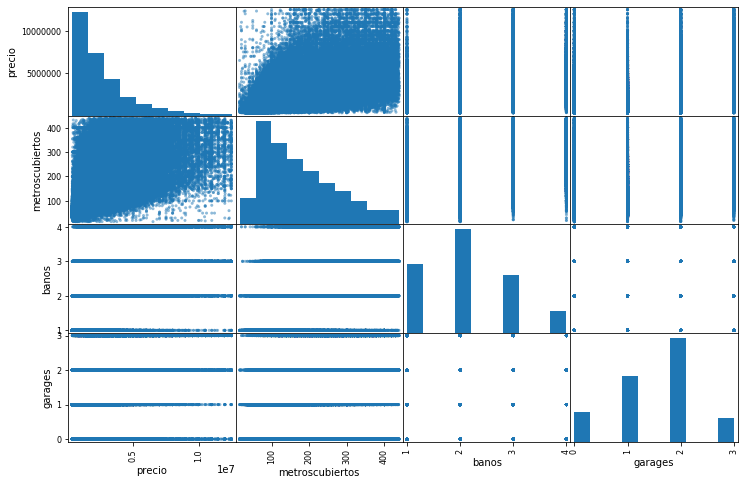

In [20]:
atributos = ['precio','metroscubiertos','banos','garages']
scatter_matrix(df[atributos], figsize = (12,8))

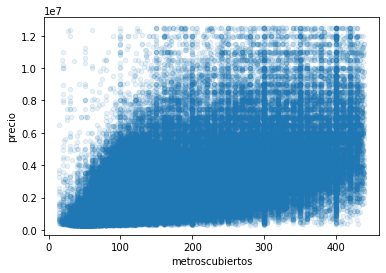

In [21]:
df.plot(kind='scatter',x='metroscubiertos',y='precio', alpha=0.1)

In [22]:
df['cub_a_tot'] = df.metroscubiertos/df.metrostotales
df['metT_a_ban'] = df.metrostotales/df.banos
df['metC_a_ban'] = df.metroscubiertos/df.banos
df['ban_a_hab'] = df.banos/df.habitaciones

In [23]:
corr_matrix = df.corr()
corr_matrix['precio'].sort_values(ascending=False)

precio                        1.000000
metroscubiertos               0.630241
banos                         0.534146
metrostotales                 0.514448
ban_a_hab                     0.437864
garages                       0.351114
metC_a_ban                    0.262409
habitaciones                  0.252065
gimnasio                      0.152562
cub_a_tot                     0.143967
usosmultiples                 0.143374
piscina                       0.112353
metT_a_ban                    0.080385
antiguedad                    0.076148
idzona                        0.074017
lng                           0.050185
centroscomercialescercanos    0.026063
escuelascercanas              0.000248
id                           -0.000416
lat                          -0.155437
Name: precio, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D2AF0B1358>,
      dtype=object)

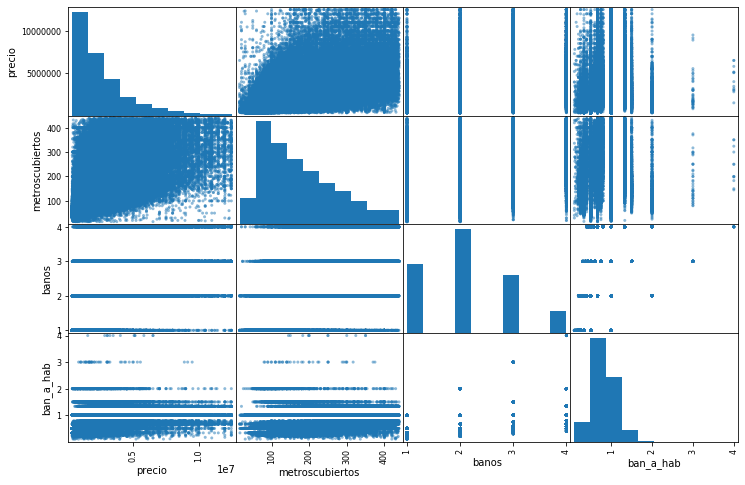

In [24]:
atributos = ['precio','metroscubiertos','banos','ban_a_hab']
scatter_matrix(df[atributos], figsize = (12,8))

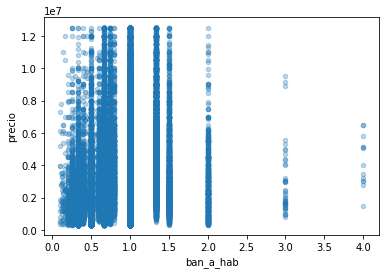

In [25]:
# Muy interesante ver como tener 3 banios por habitacion no incrementa el precio tanto como esperamos.
df.plot(kind='scatter',x='ban_a_hab',y='precio', alpha=0.3)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192000 entries, 173455 to 601
Data columns (total 27 columns):
id                            192000 non-null int64
titulo                        187719 non-null object
descripcion                   190705 non-null object
tipodepropiedad               191962 non-null object
direccion                     149586 non-null object
ciudad                        191705 non-null object
provincia                     191872 non-null object
antiguedad                    157188 non-null float64
habitaciones                  173992 non-null float64
garages                       161760 non-null float64
banos                         170983 non-null float64
metroscubiertos               177983 non-null float64
metrostotales                 150776 non-null float64
idzona                        169115 non-null float64
lat                           93190 non-null float64
lng                           93190 non-null float64
fecha                         192

In [27]:
# Queremos sacarnos de encima los NaN.  Podemos fillna o dropna.
# Vamos optar por sacarnos las columnas de lat y lng, y dropna los restos.
df_tr = df.drop(columns=['lat','lng', 'metT_a_ban','metC_a_ban'])

In [28]:
df_tr.info()
#Queda algo homogeneo y cuantitativo.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192000 entries, 173455 to 601
Data columns (total 23 columns):
id                            192000 non-null int64
titulo                        187719 non-null object
descripcion                   190705 non-null object
tipodepropiedad               191962 non-null object
direccion                     149586 non-null object
ciudad                        191705 non-null object
provincia                     191872 non-null object
antiguedad                    157188 non-null float64
habitaciones                  173992 non-null float64
garages                       161760 non-null float64
banos                         170983 non-null float64
metroscubiertos               177983 non-null float64
metrostotales                 150776 non-null float64
idzona                        169115 non-null float64
fecha                         192000 non-null datetime64[ns]
gimnasio                      192000 non-null float64
usosmultiples           

In [29]:
df_tr.banos.head()

173455    2.0
171491    2.0
206391    2.0
99089     1.0
238537    3.0
Name: banos, dtype: float64

In [30]:
quantitative = [f for f in df_tr.columns if df_tr.dtypes[f] != 'object']
qualitative = [f for f in df_tr.columns if (df_tr.dtypes[f] == 'object') and (f != 'descripcion' or f != 'titulo')]

df_tr=df_tr.drop(columns=qualitative + ['fecha'])
imputer = Imputer(strategy='median')
imputer.fit(df_tr)
X = imputer.transform(df_tr)

In [31]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192000 entries, 173455 to 601
Data columns (total 16 columns):
id                            192000 non-null int64
antiguedad                    157188 non-null float64
habitaciones                  173992 non-null float64
garages                       161760 non-null float64
banos                         170983 non-null float64
metroscubiertos               177983 non-null float64
metrostotales                 150776 non-null float64
idzona                        169115 non-null float64
gimnasio                      192000 non-null float64
usosmultiples                 192000 non-null float64
piscina                       192000 non-null float64
escuelascercanas              192000 non-null float64
centroscomercialescercanos    192000 non-null float64
precio                        192000 non-null float64
cub_a_tot                     136759 non-null float64
ban_a_hab                     167282 non-null float64
dtypes: float64(15), int6

In [32]:
# quan = [f for f in df.columns if df.dtypes[f] != 'object']
# qual = [f for f in df.columns if df.dtypes[f] == 'object']
imputed_df = pd.DataFrame(X,columns = df_tr.columns)

In [33]:
imputer.statistics_

array([1.49821000e+05, 5.00000000e+00, 3.00000000e+00, 2.00000000e+00,
       2.00000000e+00, 1.52000000e+02, 1.55000000e+02, 5.63650000e+04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.85000000e+06, 1.00000000e+00, 6.66666667e-01])

In [34]:
#Vemos que nuestra estrategia de reemplazar con el Median no deterioro mucho la correlacion.
corrImp_matrix = imputed_df.corr()
corrImp_matrix['precio'].sort_values(ascending=False)

precio                        1.000000
metroscubiertos               0.577328
banos                         0.483895
metrostotales                 0.413886
ban_a_hab                     0.384470
garages                       0.329569
habitaciones                  0.237410
gimnasio                      0.152562
usosmultiples                 0.143374
piscina                       0.112353
cub_a_tot                     0.090387
idzona                        0.073563
antiguedad                    0.065348
centroscomercialescercanos    0.026063
escuelascercanas              0.000248
id                           -0.000416
Name: precio, dtype: float64

In [35]:
df_tr.head()

,id,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,cub_a_tot,ban_a_hab
173455,106425,0.0,3.0,2.0,2.0,151.0,281.0,NaN,0.0,0.0,0.0,0.0,0.0,1475000.0,0.537367,0.666667
171491,97179,20.0,3.0,2.0,2.0,107.0,208.0,86235.0,0.0,0.0,0.0,1.0,1.0,900000.0,0.514423,0.666667
206391,59024,8.0,3.0,1.0,2.0,180.0,90.0,71635.0,0.0,0.0,0.0,0.0,0.0,850000.0,2.000000,0.666667
99089,63197,5.0,2.0,1.0,1.0,80.0,NaN,24979.0,0.0,0.0,0.0,0.0,0.0,700000.0,NaN,0.500000
238537,193118,28.0,3.0,2.0,3.0,NaN,266.0,23263.0,0.0,0.0,0.0,1.0,1.0,5700000.0,NaN,1.000000


In [36]:
qual_to_e = df[['tipodepropiedad','provincia','precio']]
qual_cols = [f for f in qual_to_e.columns] # como le saco el precio?
qual_cols = ['tipodepropiedad','provincia']

In [37]:
# Para incorporar direccion y ciudad, habria que limpiar los datos - homogeneizarlos un poco.
# Queremos modificar tipodepropiedad y provincia

def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'precio']].groupby(feature).mean()['precio']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

def enc_t(df_bin):
    quantitative = [f for f in df_bin.columns if df_bin.dtypes[f] != 'object']
    qualitative = [f for f in df_bin.columns if (df_bin.dtypes[f] == 'object') and (f != 'descripcion' or f != 'titulo')]
    data_cols = df_bin[quantitative]
    binary_enc = ce.BinaryEncoder()
    binary_encoded = binary_enc.fit_transform(df_bin[qualitative])
    data = data_cols.join(binary_encoded.add_suffix("_binary"))
    return data

def enc(df):
    qual_encoded = []
    for q in qual_cols:  
        encode(df, q)
        qual_encoded.append(q+'_E')
    return qual_encoded

from time import time

t0 = time()
enc(qual_to_e)
print(time()-t0)


5.227263450622559


In [38]:
qual_to_e.drop(columns=['tipodepropiedad','provincia','precio'],inplace=True)

In [39]:
ready_df = pd.merge(df_tr,qual_to_e,left_index=True,right_index=True)

In [40]:
imputer = Imputer(strategy='median')
imputer.fit(ready_df)
X = imputer.transform(ready_df)
imp_ready_df = pd.DataFrame(X,columns = ready_df.columns)

In [41]:
standard_scaler = StandardScaler()
standard_scaler.fit(imp_ready_df)
imp_ready_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192000 entries, 0 to 191999
Data columns (total 18 columns):
id                            192000 non-null float64
antiguedad                    192000 non-null float64
habitaciones                  192000 non-null float64
garages                       192000 non-null float64
banos                         192000 non-null float64
metroscubiertos               192000 non-null float64
metrostotales                 192000 non-null float64
idzona                        192000 non-null float64
gimnasio                      192000 non-null float64
usosmultiples                 192000 non-null float64
piscina                       192000 non-null float64
escuelascercanas              192000 non-null float64
centroscomercialescercanos    192000 non-null float64
precio                        192000 non-null float64
cub_a_tot                     192000 non-null float64
ban_a_hab                     192000 non-null float64
tipodepropiedad_E        

In [42]:
df_label = df_tr['precio']
ready_df = imp_ready_df.drop(columns='precio') # this is not necessary because I removed it higher up

In [43]:
from time import time
t0 = time()
param_grid = [
#     {'n_estimators':[30, 250, 750],'max_features':[12,15]},
#     {'bootstrap': [False], 'n_estimators':[250, 750], 'max_features':[12,15]},
    {'n_estimators':[250],'max_features':[15]} #,
#     {'bootstrap': [False], 'n_estimators':[250, 750], 'max_features':[12,15]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg,param_grid,cv=5,scoring='neg_mean_squared_error')
grid_search.fit(ready_df, df_label)
print("done in %0.3fs" % (time() - t0))

done in 1976.271s


In [44]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score),params)

1075496.8820154131 {'max_features': 15, 'n_estimators': 250}


In [45]:
df_label.mean()

2532911.712104167

Features importance: 
(0.3623002610008355, 'metroscubiertos')
(0.14952019229358277, 'provincia_E')
(0.09042003433623184, 'idzona')
(0.07834365036025531, 'metrostotales')
(0.07285246574476427, 'tipodepropiedad_E')
(0.04869579103190331, 'id')
(0.04144788220433285, 'cub_a_tot')
(0.037846859336523715, 'ban_a_hab')
(0.03599243591210754, 'antiguedad')
(0.032658284893137025, 'banos')
(0.018600110818497436, 'garages')
(0.011912547360327824, 'habitaciones')
(0.004994412075189715, 'escuelascercanas')
(0.0048979299833353486, 'centroscomercialescercanos')
(0.0036710228699836332, 'gimnasio')
(0.0035217552954729557, 'piscina')
(0.002324364483518958, 'usosmultiples')


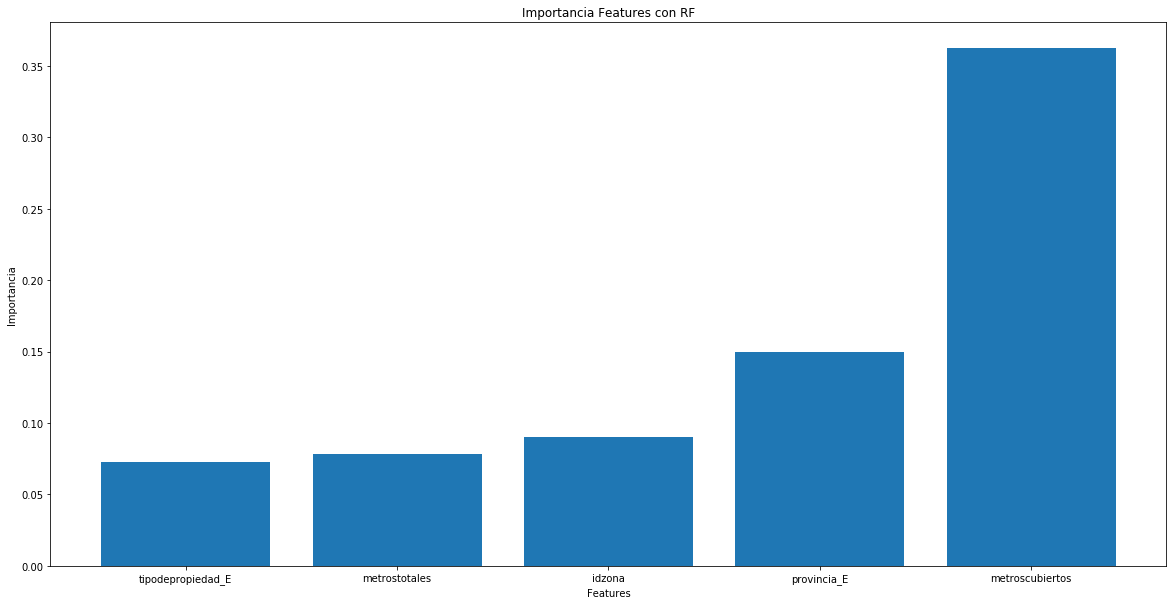

In [49]:
features_importance= grid_search.best_estimator_.feature_importances_
# features_importance
pickle.dump(grid_search.best_estimator_, open("results\\00-rf.pickle", "wb"))

print('Features importance: ')
for i in sorted(zip(features_importance,list(ready_df.columns)),reverse=True):
    print(i)

x = [y for y in sorted(zip(features_importance,list(ready_df.columns))) if y[0] > 0.05]

plt.figure(figsize=(20,10))
plt.bar([i[1] for i in x], [i[0] for i in x])
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

In [50]:
params_importance = grid_search.predict
params_importance

<function sklearn.model_selection._search.BaseSearchCV.predict(self, X)>

In [60]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48000 entries, 75083 to 64982
Data columns (total 56 columns):
id                            48000 non-null int64
antiguedad                    39257 non-null float64
habitaciones                  43537 non-null float64
garages                       40475 non-null float64
banos                         42796 non-null float64
metroscubiertos               44617 non-null float64
metrostotales                 37757 non-null float64
idzona                        42264 non-null float64
lat                           23322 non-null float64
lng                           23322 non-null float64
gimnasio                      48000 non-null float64
usosmultiples                 48000 non-null float64
piscina                       48000 non-null float64
escuelascercanas              48000 non-null float64
centroscomercialescercanos    48000 non-null float64
precio                        48000 non-null float64
tipodepropiedad_0_binary      48000 non-n

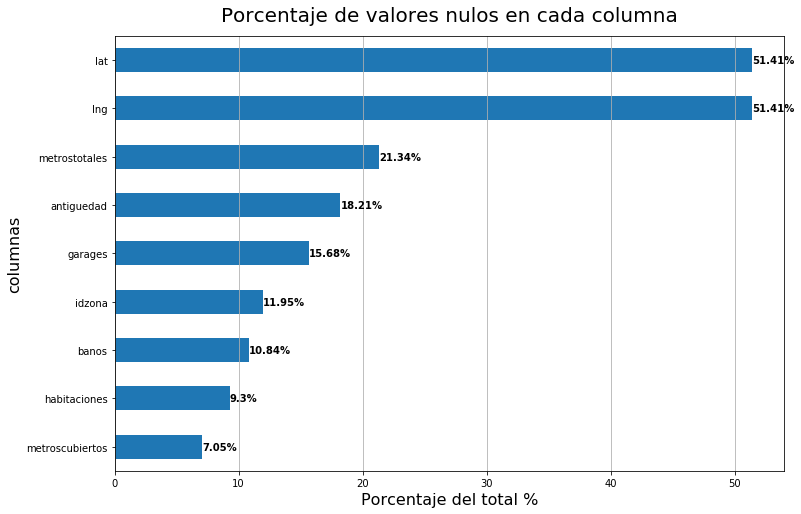

(48000, 56)

In [63]:
nulls(strat_test_set)
strat_test_set.shape

In [66]:
final_model = grid_search.best_estimator_

# Hay que ponerle todas las transformaciones que sufrió el set de entrenamiento
# strat_test_set = strat_test_set.drop(columns=['descripcion', 'titulo', 'fecha'])
# strat_test_set = strat_test_set.drop(columns=['fecha'])
strat_test_set = enc_t(strat_test_set)
X_test = strat_test_set.drop("precio", axis=1) # Armar pipeline para aplicar transformaciones.
y_test = strat_test_set['precio'].copy()
test_pred = grid_search.predict(X_test)

mse = mean_square_error(y_test,test_pred)
mrse = np.sqrt(mse)

print(mrse)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [70]:
test_df = pd.read_csv('data/test.csv', low_memory=False, parse_dates=["fecha"])
test_df = enc_t(test_df)
# test_df = test_df.drop(columns=['descripcion', 'titulo', 'fecha'])
test_df = test_df.drop(columns=['fecha'])

test_df.info()
test_pred = grid_search.predict(test_df)

answer = pd.DataFrame(list(zip(test_df.index, final_model)), columns =['id', 'predicted'])
answer.to_csv('RFpredictions.csv', sep=',', index=False, header=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 90 columns):
id                            60000 non-null int64
antiguedad                    49286 non-null float64
habitaciones                  54372 non-null float64
garages                       50677 non-null float64
banos                         53446 non-null float64
metroscubiertos               55701 non-null float64
metrostotales                 47345 non-null float64
idzona                        52821 non-null float64
lat                           29305 non-null float64
lng                           29305 non-null float64
gimnasio                      60000 non-null float64
usosmultiples                 60000 non-null float64
piscina                       60000 non-null float64
escuelascercanas              60000 non-null float64
centroscomercialescercanos    60000 non-null float64
titulo_0_binary               60000 non-null int64
titulo_1_binary               60000 non-null in

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').